# Project: Wrangling and Analyze Data

## Data Gathering

1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [1]:
import pandas as pd
import tweepy
import numpy as np
import matplotlib.pyplot as plt
import requests
from json import dumps
from PIL import Image
from io import BytesIO
pd.options.display.max_colwidth=190
pd.options.display.max_columns = None

Click here to skip to creation of all dataframes [Recreate All Dataframes](#Recreate-all-Dataframes)

Click here to skip to Cleaning Data [Cleaning](#Cleaning-Data)


In [2]:
df_archive = pd.read_csv('data/twitter_archive_enhanced.csv')
df_archive.shape

(2356, 17)

In [14]:
df_archive.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [3]:
response = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')


In [4]:
with open('data/image_predictions1.tsv', 'wb') as file:
    file.write(response.content)

In [5]:
df_images = pd.read_csv('data/image_predictions.tsv', sep='\t')
df_images.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


In [18]:
df_images.shape

(2075, 12)

In [19]:
#Do an inner merge in order to establish that all the tweets with images are contained in the tweet archives
#Get the dimensions of merged dataframe to test this
df_s = df_archive.merge(df_images, on='tweet_id', how='inner')
df_s.shape

(2075, 28)

With the test above, all the tweets referenced in the images tsv file are contained in the tweet archive file

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [6]:
#Setup tweepy

consumer_key = '<consumer_key>'
consumer_secret = '<consumer_secret>'
access_token = '<access_token>'
access_secret = '<access_secret>'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

In [8]:
# Testing the API
#Using extended mode to get full text tweet
stat = api.get_status('752334515931054080', tweet_mode='extended')
stat.full_text

In [22]:
all_tweets = []
errors = {} 
for id in df_archive.tweet_id:
    try:
        all_tweets.append(api.get_status(id, tweet_mode='extended'))
        
    except Exception as  e:
        errors[id] = e
    

In [9]:
# Test by getting an output of the retrieved tweets
all_tweets[0]._json

In [24]:
#Get a count of succesful and erroed requests
print( 'success_count:', len(all_tweets), '| error_count :', len(errors) )

success_count: 869 | error_count : 1487


### Tweepy Errors
Over 50% of the tweepy calls returned errors. Mainly due to rate limit exceeded exception.
Tweets will be stored in batches to work around this.

#### Tweepy Error Codes
- 144 - No status found with that ID.
- 179 - Sorry, you are not authorized to see this status.
- 88 - Rate limit exceeded

In [11]:
#Storing the first batch of tweets in json txt file using append mode

with open('data/tweet_json1.txt', 'a') as tweets_file:
    for status in all_tweets:
        tweets_file.write(dumps(status._json)+"\n")

In [12]:
df_json = pd.read_json('data/tweet_json.txt',lines=True)
df_json.shape

(2325, 32)

More tweepy API calls

In [14]:
x = {k: v for k, v in errors.items() if not v.args[0][0]['code'] == 179 and not v.args[0][0]['code'] == 144 }
x

In [30]:
retry_list = [i for  i in df_archive.tweet_id.tolist() if i not in df_json.id.tolist()]
len(retry_list)

1487

In [36]:
#retry API calls again after time limit
all_tweets = []
errors = {} 
for id in retry_list:
    try:
        all_tweets.append(api.get_status(id, tweet_mode='extended'))
        
    except Exception as  e:
        errors[id] = e
        
print( 'success_count:', len(all_tweets), '| error_count :', len(errors) )

success_count: 899 | error_count : 588


In [32]:
#Storing the first batch of tweets in json txt file using append mode

with open('tweet_json.txt', 'a') as tweets_file:
    for status in all_tweets:
        tweets_file.write(dumps(status._json)+"\n")

In [33]:
df_json = pd.read_json('tweet_json.txt',lines=True)

In [37]:
x = {k: v for k, v in errors.items() if not  v.args[0][0]['code'] == 144 }
x

{888202515573088257: tweepy.error.RateLimitError([{'message': 'Rate limit exceeded',
                               'code': 88}]),
 877611172832227328: tweepy.error.RateLimitError([{'message': 'Rate limit exceeded',
                               'code': 88}]),
 873697596434513921: tweepy.error.RateLimitError([{'message': 'Rate limit exceeded',
                               'code': 88}]),
 872668790621863937: tweepy.error.RateLimitError([{'message': 'Rate limit exceeded',
                               'code': 88}]),
 872261713294495745: tweepy.error.RateLimitError([{'message': 'Rate limit exceeded',
                               'code': 88}]),
 869988702071779329: tweepy.error.RateLimitError([{'message': 'Rate limit exceeded',
                               'code': 88}]),
 866816280283807744: tweepy.error.RateLimitError([{'message': 'Rate limit exceeded',
                               'code': 88}]),
 861769973181624320: tweepy.error.RateLimitError([{'message': 'Rate limit exceeded'

In [158]:
#Another retry is necessary as the rate limit has been exceeded yet again
#Recreate retry list
retry_list = [i for  i in df_archive.tweet_id.tolist() if i not in df_json.id.tolist()]
len(retry_list)

588

In [159]:
#retry API calls again after time limit
all_tweets = []
errors = {} 
for id in retry_list:
    try:
        all_tweets.append(api.get_status(id, tweet_mode='extended'))
        
    except Exception as  e:
        errors[id] = e
        
print( 'success_count:', len(all_tweets), '| error_count :', len(errors) )

success_count: 557 | error_count : 31


In [160]:
x = {k: v for k, v in errors.items() if not  v.args[0][0]['code'] == 144 }
x

{877611172832227328: tweepy.error.TweepError([{'code': 179,
                           'message': 'Sorry, you are not authorized to see this status.'}]),
 839290600511926273: tweepy.error.TweepError([{'code': 179,
                           'message': 'Sorry, you are not authorized to see this status.'}]),
 771004394259247104: tweepy.error.TweepError([{'code': 179,
                           'message': 'Sorry, you are not authorized to see this status.'}])}

In [161]:
#errors
# A final set of 31  unrecovarble exceptions were encountered
#28 of which were "No status found with that ID."
#3 of which were "Sorry, you are not authorized to see this status."
print('error_count :', len(errors) )

error_count : 31


In [162]:
#Storing the final batch of tweets in json txt file using append mode

with open('data/tweet_json1.txt', 'a') as tweets_file:
    for status in all_tweets:
        tweets_file.write(dumps(status._json)+"\n")

In [15]:
#Final shape of df
df_all_json = pd.read_json('data/tweet_json.txt',lines=True)
df_all_json.shape

(2325, 32)

###  _Recreate all Dataframes_
Recreating all dataframes in a single cell as the base files for all dataframes have been retrieved and stored
This is for ease of further analysis

In [16]:
df_archive = pd.read_csv('data/twitter_archive_enhanced.csv')
df_images = pd.read_csv('data/image_predictions.tsv', sep='\t')
df_all_json = pd.read_json('data/tweet_json.txt',lines=True)

## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [18]:
df_archive.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None


In [25]:
#Records containing retweets and replies to be excluded from analysis
len(df_archive[(df_archive.in_reply_to_status_id.isnull()==False) | (df_archive.retweeted_status_id.isnull()==False)])

259

In [26]:
#Tweet_id field is an integer. Since this is not a numerical value, it should be changed to string
# Also the data type for rating numerator and denominator should be changed to float as these values can possibly contain decimals
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [27]:
#543 records found which were not recognized as dogs
len(df_images[df_images.p3_dog==False])

576

In [28]:
df_all_json[df_all_json.retweeted==True]

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status


In [29]:
df_all_json.head(2)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'media_url': 'http://pbs.twimg...","{'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'media_url_https': 'https://pbs...","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,NaN,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs®', 'screen_name': 'dog_rates', 'location': '', 'description': 'Your Only Source For Professional Dog Ratings Instagram and ...",NaN,NaN,None,NaN,False,6875,32870,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1,2017-08-01 00:17:27+00:00,892177421306343426,892177421306343424,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 892177413194625024, 'id_str': '892177413194625024', 'indices': [139, 162], 'media_url': 'http://pbs.twim...","{'media': [{'id': 892177413194625024, 'id_str': '892177413194625024', 'indices': [139, 162], 'media_url': 'http://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg', 'media_url_https': 'https://pb...","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,NaN,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs®', 'screen_name': 'dog_rates', 'location': '', 'description': 'Your Only Source For Professional Dog Ratings Instagram and ...",NaN,NaN,None,NaN,False,5176,28399,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


In [30]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [31]:
df_images[['p1','p2','p3']][(df_images.p1_dog==False) & ((df_images.p2_dog==True) | (df_images.p3_dog==True) ) ]#.value_counts()

,p1,p2,p3
8,shopping_cart,shopping_basket,golden_retriever
22,ox,Newfoundland,groenendael
33,llama,Irish_terrier,dingo
43,seat_belt,miniature_pinscher,Chihuahua
52,hay,Rottweiler,water_buffalo
...,...,...,...
1984,basketball,pug,dalmatian
1992,laptop,French_bulldog,printer
2013,tricycle,Labrador_retriever,Pembroke
2026,web_site,dhole,golden_retriever


In [32]:
df_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [33]:
# df_all_json[df_all_json.id == 752334515931054080]
df_all_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2325 entries, 0 to 2324
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2325 non-null   datetime64[ns, UTC]
 1   id                             2325 non-null   int64              
 2   id_str                         2325 non-null   int64              
 3   full_text                      2325 non-null   object             
 4   truncated                      2325 non-null   bool               
 5   display_text_range             2325 non-null   object             
 6   entities                       2325 non-null   object             
 7   extended_entities              2055 non-null   object             
 8   source                         2325 non-null   object             
 9   in_reply_to_status_id          77 non-null     float64            
 10  in_reply_to_status_id_st

In [34]:
df_archive[df_archive.tweet_id.duplicated()]#head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [35]:
# Records with inaccurate denominators
len(df_archive[(df_archive.rating_denominator!=10)])

23

In [36]:
df_archive[(df_archive.rating_denominator!=10)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/ph...",84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1",24,7,Sam,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/ph...",9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244762497024/video/1,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/ph...",9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023742988288/photo/1,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582966214656/photo/1,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This

In [37]:
#Checking dog names
df_archive.name.value_counts()

None          745
a              55
Charlie        12
Cooper         11
Lucy           11
             ... 
Dex             1
Ace             1
Tayzie          1
Grizzie         1
Christoper      1
Name: name, Length: 957, dtype: int64

In [38]:
df_archive.floofer.value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [39]:
df_archive[(df_archive.doggo=='doggo') & (df_archive.puppo=='puppo' )]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
191,855851453814013952,NaN,NaN,2017-04-22 18:31:02 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel,NaN,NaN,NaN,https://twitter.com/dog_rates/status/855851453814013952/photo/1,13,10,None,doggo,None,None,puppo


In [40]:
#Test to check if the classifications of floffer,doggo,puppo,pupper are mutually exclusive (they are not)
# Test also shows that 1976 records are without any classification 
df_archive.groupby(['floofer','doggo','puppo','pupper']).tweet_id.count()

floofer  doggo  puppo  pupper
None     None   None   None      1976
                       pupper     245
                puppo  None        29
         doggo  None   None        83
                       pupper      12
                puppo  None         1
floofer  None   None   None         9
         doggo  None   None         1
Name: tweet_id, dtype: int64

### Quality issues

1. tweet_archive_enhanced.csv includes replies and retweets which are not meant to feature in analysis (df_archive)

2. timestamp column should be represented as a datetime instead of as a string (df_archive)

3. rating_numerator and rating denominator column should be represended as a float as these columns could contain floating numbers (df_archive)

4. 23 records in the the tweet_archive_enchanced.csv have inaccurate data as the denominators are less than 10  (df_archive)
    re-compute inaccurate ratings using tweet text

5. 543 records found in image_prediction.tsv which were not recognized as dogs using first prediction method  (df_images)

6. tweet_id column in the tweet_archive_enchanced.csv should be represented as an object instead of as an integer as it is not treated as a numerical field. The same applies to tweet_id column in the image_prediction.tsv and  id in the tweet_json.txt (df_archive, df_images, df_all_json)

7. 55 dogs are recorded as having the name "**a**" in the tweet_archive_enchanced.csv this is an inaccurate name and needs to be looked into. Some other inaccurate names were spotted also  (df_archive)

8. 31 tweet records could not be retrieved using tweepy into tweet_json.txt, therefore the data on favorite count cannot be derived.  (df_all_json)

### Tidiness issues
1. The dog classification of doggo, pupper, puppo, floffer should be collapsed into 1 column

2. Since a dog has only one breed (1 to 1 relationship) the dog breed name should be extracted from the image_prediction.tsv and appended to the tweet_archive.csv. This also applies to the jpg_url field. Also the retweet_count and the favorites_count field should be extracted from the tweet_json.txt dataset and appended onto the tweet_archive_enhanced dataset as this is also a 1-to-1 relationship. 

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [42]:
# Make copies of original pieces of data
df_archive = pd.read_csv('data/twitter_archive_enhanced.csv')
df_images = pd.read_csv('data/image_predictions.tsv', sep='\t')
df_all_json = pd.read_json('data/tweet_json.txt',lines=True)

df_archive_copy = df_archive.copy()
df_images_copy = df_images.copy()
df_all_json_copy = df_all_json.copy()

### Issue #1: 
tweet_archive_enhanced.csv includes replies and retweets which are not meant to feature in analysis (df_archive)

#### Define:
- Drop all rows that have a value for in_reply_to_status_id or retweeted_status_id  

- Drop unused retweet and reply  columns
   - "in_reply_to_status_id", 
   - "in_reply_to_user_id" , 
   - "retweeted_status_id", 
   - "retweeted_status_user_id" 
   - "retweeted_status_timestamp"

#### Code

In [43]:
#length of df before elimination of replies and retweets
len(df_archive_copy)

2356

In [44]:
df_archive_copy = df_archive_copy[df_archive_copy.in_reply_to_status_id.isnull()]
df_archive_copy = df_archive_copy[df_archive_copy.retweeted_status_id.isnull()]

df_archive_copy.drop('in_reply_to_status_id', axis=1, inplace=True)
df_archive_copy.drop('in_reply_to_user_id', axis=1, inplace=True)
df_archive_copy.drop('retweeted_status_id', axis=1, inplace=True)
df_archive_copy.drop('retweeted_status_user_id', axis=1, inplace=True)
df_archive_copy.drop('retweeted_status_timestamp', axis=1, inplace=True)

#### Test

In [45]:
df_archive_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2097 non-null   int64 
 1   timestamp           2097 non-null   object
 2   source              2097 non-null   object
 3   text                2097 non-null   object
 4   expanded_urls       2094 non-null   object
 5   rating_numerator    2097 non-null   int64 
 6   rating_denominator  2097 non-null   int64 
 7   name                2097 non-null   object
 8   doggo               2097 non-null   object
 9   floofer             2097 non-null   object
 10  pupper              2097 non-null   object
 11  puppo               2097 non-null   object
dtypes: int64(3), object(9)
memory usage: 213.0+ KB


### Issue #2: 
timestamp column should be represented as a datetime instead of as a string (df_archive) 

#### Define: 
Change datatype for timestamp to datetime

#### Code

In [46]:
df_archive_copy.timestamp = pd.to_datetime(df_archive_copy.timestamp)

#### Test

In [47]:
df_archive_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2097 non-null   int64              
 1   timestamp           2097 non-null   datetime64[ns, UTC]
 2   source              2097 non-null   object             
 3   text                2097 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2097 non-null   int64              
 6   rating_denominator  2097 non-null   int64              
 7   name                2097 non-null   object             
 8   doggo               2097 non-null   object             
 9   floofer             2097 non-null   object             
 10  pupper              2097 non-null   object             
 11  puppo               2097 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(3

### Issue #3: 
rating_numerator and rating_denominator column should be represended as a float as these columns could contain floating numbers (df_archive)

#### Define: 
Change data type for rating_numerator and rating_denominator columns to float

#### Code

In [48]:
df_archive_copy.rating_numerator = df_archive_copy.rating_numerator.astype(float)
df_archive_copy.rating_denominator = df_archive_copy.rating_denominator.astype(float)

#### Test

In [49]:
df_archive_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2097 non-null   int64              
 1   timestamp           2097 non-null   datetime64[ns, UTC]
 2   source              2097 non-null   object             
 3   text                2097 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2097 non-null   float64            
 6   rating_denominator  2097 non-null   float64            
 7   name                2097 non-null   object             
 8   doggo               2097 non-null   object             
 9   floofer             2097 non-null   object             
 10  pupper              2097 non-null   object             
 11  puppo               2097 non-null   object             
dtypes: datetime64[ns, UTC](1), float64

### Issue #4: 
23 records with inaccurate denominators (denominator < 10)  (df_archive)


#### Define:  Re-compute inaccurate ratings using tweet text
Extract rating numerator and denominator from tweet text
Replace invalid ratings with extracted ratings
drop ratings df

#### Code

In [50]:
ratings = df_archive_copy.text.str.extract(r'(\d+\.\d*/10+|\d+/10)', expand =False)
split_ratings = ratings.str.split('/',expand=True)
# ratings[1:2322]

In [51]:
split_ratings = ratings.str.split('/',expand=True)
split_ratings.dropna(inplace=True)
# split_ratings.columns = ['new_num','new_denom']
split_ratings.rename(columns={0:'new_num',1:'new_denom'}, inplace=True)
split_ratings.new_num = split_ratings.new_num.astype(float)
split_ratings.new_denom = split_ratings.new_denom.astype(float)

split_ratings.head()


,new_num,new_denom
0,13.0,10.0
1,13.0,10.0
2,12.0,10.0
3,13.0,10.0
4,12.0,10.0


In [52]:
df_archive_copy = df_archive_copy.join(split_ratings,how='outer')#.head(2)


In [53]:
#12 invalid rows dont have a corresponding new numerator / new denominator
#These records are either not tweets of dogs, or the tweet rated a group of dogs
#These records would lead to errors in analysis, therefore they will be dropped
#See them below
len(df_archive_copy[df_archive_copy.new_num.isna()])
df_archive_copy[df_archive_copy.new_num.isna()]


,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,new_num,new_denom
433,820690176645140481,2017-01-15 17:52:40+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/ph...",84.0,70.0,None,None,None,None,None,NaN,NaN
516,810984652412424192,2016-12-19 23:06:23+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1",24.0,7.0,Sam,None,None,None,None,NaN,NaN
902,758467244762497024,2016-07-28 01:00:57+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,https://twitter.com/dog_rates/status/758467244762497024/video/1,165.0,150.0,None,None,None,None,None,NaN,NaN
1120,731156023742988288,2016-05-13 16:15:54+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,https://twitter.com/dog_rates/status/731156023742988288/photo/1,204.0,170.0,this,None,None,None,None,NaN,NaN
1228,713900603437621249,2016-03-27 01:29:02+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,https://twitter.com/dog_rates/status/713900603437621249/photo/1,99.0,90.0,None,None,None,None,None,NaN,NaN
1254,710658690886586372,2016-03-18 02:46:49+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,https://twitter.com/dog_rates/status/710658690886586372/photo/1,80.0,80.0,None,None,None,None,None,NaN,NaN
1274,709198395643068416,2016-03-14 02:04:08+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",https://twitter.com/dog_rates/status/709198395643068416/photo/1,45.0,50.0,None,None,None,None,None,NaN,NaN
1351,704054845121142784,2016-02-28 21:25:30+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,https://twitter.com/dog_rates/status/704054845121142784/photo/1,60.0,50.0,a,None,None,None,None,NaN,NaN
1433,697463031882764288,2016-02-10 16:51:59+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,https://twitter.com/dog_rates/status/697463031882764288/photo/1,44.0,40.0,None,None,None,None,None,NaN,NaN
1635,684222868335505415,2016-01-05 04:00:18+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55,https://twitter.com/dog_rates/status/684222868335505415/photo/1,121.0,110.0,None,None,None,None,None,NaN,NaN


In [54]:
df_archive_copy.dropna(subset=['new_num'],inplace=True)

In [55]:
#Query all records that have thier ratings different from the recomputed ratings
df_inaccurate_ratings = df_archive_copy[(df_archive_copy.new_num!= df_archive_copy.rating_numerator) 
                | (df_archive_copy.new_denom!= df_archive_copy.rating_denominator)] 

df_inaccurate_ratings


,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,new_num,new_denom
45,883482846933004288,2017-07-08 00:28:19+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948","https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",5.0,10.0,Bella,None,None,None,None,13.50,10.0
695,786709082849828864,2016-10-13 23:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",https://twitter.com/dog_rates/status/786709082849828864/photo/1,75.0,10.0,Logan,None,None,None,None,9.75,10.0
763,778027034220126208,2016-09-20 00:24:34+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,https://twitter.com/dog_rates/status/778027034220126208/photo/1,27.0,10.0,Sophie,None,None,pupper,None,11.27,10.0
1068,740373189193256964,2016-06-08 02:41:38+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ","https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/ph...",9.0,11.0,None,None,None,None,None,14.00,10.0
1165,722974582966214656,2016-04-21 02:25:47+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,https://twitter.com/dog_rates/status/722974582966214656/photo/1,4.0,20.0,None,None,None,None,None,13.00,10.0
1202,716439118184652801,2016-04-03 01:36:11+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,https://twitter.com/dog_rates/status/716439118184652801/photo/1,50.0,50.0,Bluebert,None,None,None,None,11.00,10.0
1662,682962037429899265,2016-01-01 16:30:13+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,https://twitter.com/dog_rates/status/682962037429899265/photo/1,7.0,11.0,Darrel,None,None,None,None,10.00,10.0
1712,680494726643068929,2015-12-25 21:06:00+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,https://twitter.com/dog_rates/status/680494726643068929/photo/1,26.0,10.0,None,None,None,None,None,11.26,10.0
2335,666287406224695296,2015-11-16 16:11:11+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,https://twitter.com/dog_rates/status/666287406224695296/photo/1,1.0,2.0,an,None,None,None,None,9.00,10.0


In [56]:
#Set rating numerator to new_num
df_archive_copy.loc[(df_archive_copy.new_num!= df_archive_copy.rating_numerator) 
                | (df_archive_copy.new_denom!= df_archive_copy.rating_denominator), ['rating_numerator'] ]      = df_archive_copy[(df_archive_copy.new_num!= df_archive_copy.rating_numerator) 
                | (df_archive_copy.new_denom!= df_archive_copy.rating_denominator)]['new_num']

#Set rating denominator to new_denum
df_archive_copy.loc[(df_archive_copy.new_num!= df_archive_copy.rating_numerator) 
                | (df_archive_copy.new_denom!= df_archive_copy.rating_denominator), ['rating_denominator'] ]      = df_archive_copy[(df_archive_copy.new_num!= df_archive_copy.rating_numerator) 
                | (df_archive_copy.new_denom!= df_archive_copy.rating_denominator)]['new_denom']

df_archive_copy.rating_numerator = df_archive_copy.rating_numerator.astype(float)
df_archive_copy.rating_denominator = df_archive_copy.rating_denominator.astype(float)

# df_archive_copy[(df_archive_copy.new_num!= df_archive_copy.rating_numerator) 
#                 | (df_archive_copy.new_denom!= df_archive_copy.rating_denominator)] 


In [57]:
#Drop columns for new_num and new_denom
df_archive_copy.drop(['new_num','new_denom'], axis=1, inplace=True)

In [58]:
df_archive_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2085 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2085 non-null   int64              
 1   timestamp           2085 non-null   datetime64[ns, UTC]
 2   source              2085 non-null   object             
 3   text                2085 non-null   object             
 4   expanded_urls       2082 non-null   object             
 5   rating_numerator    2085 non-null   float64            
 6   rating_denominator  2085 non-null   float64            
 7   name                2085 non-null   object             
 8   doggo               2085 non-null   object             
 9   floofer             2085 non-null   object             
 10  pupper              2085 non-null   object             
 11  puppo               2085 non-null   object             
dtypes: datetime64[ns, UTC](1), float64

#### Test

In [59]:
df_inaccurate_ratings

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,new_num,new_denom
45,883482846933004288,2017-07-08 00:28:19+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948","https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",5.0,10.0,Bella,None,None,None,None,13.50,10.0
695,786709082849828864,2016-10-13 23:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",https://twitter.com/dog_rates/status/786709082849828864/photo/1,75.0,10.0,Logan,None,None,None,None,9.75,10.0
763,778027034220126208,2016-09-20 00:24:34+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,https://twitter.com/dog_rates/status/778027034220126208/photo/1,27.0,10.0,Sophie,None,None,pupper,None,11.27,10.0
1068,740373189193256964,2016-06-08 02:41:38+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ","https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/ph...",9.0,11.0,None,None,None,None,None,14.00,10.0
1165,722974582966214656,2016-04-21 02:25:47+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,https://twitter.com/dog_rates/status/722974582966214656/photo/1,4.0,20.0,None,None,None,None,None,13.00,10.0
1202,716439118184652801,2016-04-03 01:36:11+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,https://twitter.com/dog_rates/status/716439118184652801/photo/1,50.0,50.0,Bluebert,None,None,None,None,11.00,10.0
1662,682962037429899265,2016-01-01 16:30:13+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,https://twitter.com/dog_rates/status/682962037429899265/photo/1,7.0,11.0,Darrel,None,None,None,None,10.00,10.0
1712,680494726643068929,2015-12-25 21:06:00+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,https://twitter.com/dog_rates/status/680494726643068929/photo/1,26.0,10.0,None,None,None,None,None,11.26,10.0
2335,666287406224695296,2015-11-16 16:11:11+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,https://twitter.com/dog_rates/status/666287406224695296/photo/1,1.0,2.0,an,None,None,None,None,9.00,10.0


In [60]:
df_archive_copy[df_archive_copy.rating_denominator!=10]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [61]:
#Inaccurate ratings have been resolved as seen here
df_archive_copy[df_archive_copy.tweet_id.isin(df_inaccurate_ratings.tweet_id)]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
45,883482846933004288,2017-07-08 00:28:19+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948","https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",13.50,10.0,Bella,None,None,None,None
695,786709082849828864,2016-10-13 23:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",https://twitter.com/dog_rates/status/786709082849828864/photo/1,9.75,10.0,Logan,None,None,None,None
763,778027034220126208,2016-09-20 00:24:34+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,https://twitter.com/dog_rates/status/778027034220126208/photo/1,11.27,10.0,Sophie,None,None,pupper,None
1068,740373189193256964,2016-06-08 02:41:38+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ","https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/ph...",14.00,10.0,None,None,None,None,None
1165,722974582966214656,2016-04-21 02:25:47+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,https://twitter.com/dog_rates/status/722974582966214656/photo/1,13.00,10.0,None,None,None,None,None
1202,716439118184652801,2016-04-03 01:36:11+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,https://twitter.com/dog_rates/status/716439118184652801/photo/1,11.00,10.0,Bluebert,None,None,None,None
1662,682962037429899265,2016-01-01 16:30:13+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,https://twitter.com/dog_rates/status/682962037429899265/photo/1,10.00,10.0,Darrel,None,None,None,None
1712,680494726643068929,2015-12-25 21:06:00+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,https://twitter.com/dog_rates/status/680494726643068929/photo/1,11.26,10.0,None,None,None,None,None
2335,666287406224695296,2015-11-16 16:11:11+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,https://twitter.com/dog_rates/status/666287406224695296/photo/1,9.00,10.0,an,None,None,None,None


### Issue #5: 
543 records found in image-prediction.tsv which were not recognized as dogs using first prediction method (df_images)

#### Define: 
- Get all records that were not predicted to be dogs using the first prediction (p1) method.
- if the second prediction method (p2) provided a dog prediction, replace the prediction in p1 with p2
- else if the third prediction method (p3) provided a dog prediction, replace the prediction in p1 with p3
- else leave prediction as it is

- Drop p2 and p3 columns

#### Code

In [62]:
#Records that were predicted as dogs vs records not predicted as dogs using p1
dogs = len(df_images_copy[df_images_copy.p1_dog==True])
not_dogs= len(df_images_copy[df_images_copy.p1_dog==False])
'Dogs :'+str(dogs), 'Not Dogs :'+str(not_dogs)

('Dogs :1532', 'Not Dogs :543')

In [63]:
#Records which were not predicted as dogs using p1 but predicted as dogs using p2 or p3
subs = len(df_images[['p1','p2','p3']][(df_images.p1_dog==False) & ((df_images.p2_dog==True) | (df_images.p3_dog==True) ) ])
subs

219

219 extra dog predictions will be added onto p1. Following this P2 and P3 will be dropped

In [64]:
'Final expected number of dog predictions ='+str(dogs+subs)

'Final expected number of dog predictions =1751'

In [65]:
#Define functions to do substitution of dog predictions

def dog_rating(df) : 
#     print(df)
    if df['p1_dog']:
        return df['p1']
    elif df['p2_dog']:
        return df['p2']
    elif df['p3_dog']:
        return df['p3']
    
    return df['p1']

def is_dog(df) : 
#     print(df)
    if df['p1_dog']:
        return df['p1_dog']
    elif df['p2_dog']:
        return df['p2_dog']
    elif df['p3_dog']:
        return df['p3_dog']
    
    return df['p1_dog']



In [66]:
#perform substitutions for p1 where applicable
df_images_copy.p1 = df_images_copy.apply(dog_rating,axis=1)
df_images_copy.p1_dog = df_images_copy.apply(is_dog,axis=1)

In [67]:
df_images_copy.drop(['p2','p2_conf','p2_dog','p3','p3_conf','p3_dog'], axis=1, inplace=True)

#### Test

In [68]:
#Records that were predicted as dogs vs records not predicted as dogs using p1
dogs1 = len(df_images_copy[df_images_copy.p1_dog==True])
not_dogs1= len(df_images_copy[df_images_copy.p1_dog==False])
'Dogs :'+str(dogs1), 'Not Dogs :'+str(not_dogs1)

('Dogs :1751', 'Not Dogs :324')

In [69]:
df_images_copy.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True


### Issue #6: 
tweet_id column should be represented as an object instead of as an integer as this field is not treated as a numerical field (df_archive)

#### Define: 
- Change datatype for tweet_id to string

#### Code

In [70]:
df_archive_copy.tweet_id = df_archive_copy.tweet_id.astype(str)
df_images_copy.tweet_id = df_images_copy.tweet_id.astype(str)
df_all_json_copy.id = df_all_json_copy.id.astype(str)

#### Test

In [71]:
df_archive_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2085 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2085 non-null   object             
 1   timestamp           2085 non-null   datetime64[ns, UTC]
 2   source              2085 non-null   object             
 3   text                2085 non-null   object             
 4   expanded_urls       2082 non-null   object             
 5   rating_numerator    2085 non-null   float64            
 6   rating_denominator  2085 non-null   float64            
 7   name                2085 non-null   object             
 8   doggo               2085 non-null   object             
 9   floofer             2085 non-null   object             
 10  pupper              2085 non-null   object             
 11  puppo               2085 non-null   object             
dtypes: datetime64[ns, UTC](1), float64

### Issue #7: 
55 dogs are recorded as having the name "a" in the tweet_archive_enchanced.csv this is an inaccurate name and needs to be looked into. Some other inaccurate names were spotted also (df_archive)

#### Define: 
- Investigate tweet text to see if names were provided for dogs named "a"
- If named, update name, else leave as is

#### Code

In [72]:
df_archive_copy[df_archive_copy.name.str.contains(r'^[a-z]')]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
22,887517139158093824,2017-07-19 03:39:09+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy) https://t.co/20VrLAA8ba,https://twitter.com/dog_rates/status/887517139158093824/video/1,14.0,10.0,such,None,None,None,None
56,881536004380872706,2017-07-02 15:32:16+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF,https://twitter.com/dog_rates/status/881536004380872706/video/1,14.0,10.0,a,None,None,pupper,None
169,859196978902773760,2017-05-02 00:04:57+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10 https://t.co/g2nSyGenG9,https://twitter.com/dog_rates/status/859196978902773760/video/1,12.0,10.0,quite,None,None,None,None
193,855459453768019968,2017-04-21 16:33:22+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Guys, we only rate dogs. This is quite clearly a bulbasaur. Please only send dogs. Thank you... 12/10 human used pet, it's super effective https://t.co/Xc7uj1C64x","https://twitter.com/dog_rates/status/855459453768019968/photo/1,https://twitter.com/dog_rates/status/855459453768019968/photo/1",12.0,10.0,quite,None,None,None,None
335,832645525019123713,2017-02-17 17:38:57+00:00,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",There's going to be a dog terminal at JFK Airport. This is not a drill. 10/10 \nhttps://t.co/dp5h9bCwU7,http://us.blastingnews.com/news/2017/02/jfk-announces-its-first-ever-ark-oasis-animal-terminal-001480161.html?sbdht=_pM1QUzk3wsdTxcmMoRPV7FWYYlsNKcFRcYSY7OmeHnOXA4NtUM6PLQ2_,10.0,10.0,not,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...
2349,666051853826850816,2015-11-16 00:35:11+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an odd dog. Hard on the outside but loving on the inside. Petting still fun. Doesn't play catch well. 2/10 https://t.co/v5A4vzSDdc,https://twitter.com/dog_rates/status/666051853826850816/photo/1,2.0,10.0,an,None,None,None,None
2350,666050758794694657,2015-11-16 00:30:50+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a truly beautiful English Wilson Staff retriever. Has a nice phone. Privileged. 10/10 would trade lives with https://t.co/fvIbQfHjIe,https://twitter.com/dog_rates/status/666050758794694657/photo/1,10.0,10.0,a,None,None,None,None
2352,666044226329800704,2015-11-16 00:04:52+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6.0,10.0,a,None,None,None,None
2353,666033412701032449,2015-11-15 23:21:54+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9.0,10.0,a,None,None,None,None


In [73]:
#Records of dogs named "a"
df_named_a = df_archive_copy[df_archive_copy.name=='a']

After visually investigating the text, it was observed that most of these records do not contain the name of the dog. However, there were some records where the name of the dog came after the word "named" or words "name is". 

We can use this information to extract the name of the dogs in these instances

In [74]:
#Extract the names using the pattern
raw_extract = df_archive_copy[df_archive_copy.name=='a'].text.str.extract(r'(named [a-zA-Z]+|name is [a-zA-Z]+)')

#Remove the first part of the extract (i.e "named" or "name is" and retain name)
names = raw_extract.apply(lambda x: str(x[0]).split(' ')[-1] if not x[0] is np.NaN else 'a', axis=1)
names

56              a
649             a
801             a
1002            a
1004            a
1017            a
1049            a
1193            a
1207            a
1340            a
1361            a
1368            a
1382            a
1499            a
1737            a
1785            a
1853        Wylie
1854            a
1877            a
1878            a
1923            a
1941            a
1955          Kip
1994            a
2034        Jacob
2066        Rufus
2116        Spork
2125     Cherokee
2128        Hemry
2146      Alphred
2153            a
2161      Alfredo
2191        Leroi
2198            a
2211            a
2218         Chuk
2222            a
2235      Alfonso
2249       Cheryl
2255      Jessiga
2264        Klint
2273         Kohl
2287        Daryl
2304         Pepe
2311    Octaviath
2314         Johm
2327            a
2334            a
2347            a
2348            a
2350            a
2352            a
2353            a
2354            a
dtype: object

In [75]:
df_archive_copy.loc[df_archive_copy.name=='a','name'] = names

In [76]:
df_archive_copy.iloc[1853:1854]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2118,670420569653809152,2015-11-28 01:54:54+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Damon. The newest presidential candidate for 2016. 10/10 he gets my vote https://t.co/Z5nqlfjYJi,https://twitter.com/dog_rates/status/670420569653809152/photo/1,10.0,10.0,Damon,None,None,None,None


In [77]:
#Equality in the two values below shows that no additional records were reclassified
'Count of dogs named "a" was : '+str(len(df_named_a)), 'After amendments, count of dogs named "a" is :'+str(len(df_archive_copy[df_archive_copy.name=='a']))

('Count of dogs named "a" was : 54',
 'After amendments, count of dogs named "a" is :34')

In [78]:
#Visually inspect remaining wrongly named records
df_archive_copy[df_archive_copy.name.str.contains(r'^[a-z]')]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
22,887517139158093824,2017-07-19 03:39:09+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy) https://t.co/20VrLAA8ba,https://twitter.com/dog_rates/status/887517139158093824/video/1,14.0,10.0,such,None,None,None,None
56,881536004380872706,2017-07-02 15:32:16+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF,https://twitter.com/dog_rates/status/881536004380872706/video/1,14.0,10.0,a,None,None,pupper,None
169,859196978902773760,2017-05-02 00:04:57+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10 https://t.co/g2nSyGenG9,https://twitter.com/dog_rates/status/859196978902773760/video/1,12.0,10.0,quite,None,None,None,None
193,855459453768019968,2017-04-21 16:33:22+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Guys, we only rate dogs. This is quite clearly a bulbasaur. Please only send dogs. Thank you... 12/10 human used pet, it's super effective https://t.co/Xc7uj1C64x","https://twitter.com/dog_rates/status/855459453768019968/photo/1,https://twitter.com/dog_rates/status/855459453768019968/photo/1",12.0,10.0,quite,None,None,None,None
335,832645525019123713,2017-02-17 17:38:57+00:00,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",There's going to be a dog terminal at JFK Airport. This is not a drill. 10/10 \nhttps://t.co/dp5h9bCwU7,http://us.blastingnews.com/news/2017/02/jfk-announces-its-first-ever-ark-oasis-animal-terminal-001480161.html?sbdht=_pM1QUzk3wsdTxcmMoRPV7FWYYlsNKcFRcYSY7OmeHnOXA4NtUM6PLQ2_,10.0,10.0,not,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...
2349,666051853826850816,2015-11-16 00:35:11+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an odd dog. Hard on the outside but loving on the inside. Petting still fun. Doesn't play catch well. 2/10 https://t.co/v5A4vzSDdc,https://twitter.com/dog_rates/status/666051853826850816/photo/1,2.0,10.0,an,None,None,None,None
2350,666050758794694657,2015-11-16 00:30:50+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a truly beautiful English Wilson Staff retriever. Has a nice phone. Privileged. 10/10 would trade lives with https://t.co/fvIbQfHjIe,https://twitter.com/dog_rates/status/666050758794694657/photo/1,10.0,10.0,a,None,None,None,None
2352,666044226329800704,2015-11-16 00:04:52+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6.0,10.0,a,None,None,None,None
2353,666033412701032449,2015-11-15 23:21:54+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9.0,10.0,a,None,None,None,None


In [79]:
#Set all wrongly named records to None
df_archive_copy.loc[df_archive_copy.name.str.contains(r'^[a-z]'), 'name'] = None

#### Test

In [80]:
#Equality in the two values below shows that no additional records were reclassified
'Count of dogs named "a" was : '+str(len(df_named_a)), 'After amendments, count of dogs named "a" is :'+str(len(df_archive_copy[df_archive_copy.name=='a']))

('Count of dogs named "a" was : 54',
 'After amendments, count of dogs named "a" is :0')

In [81]:
'Count of updated names from dogs named "a" is : '+str(len(df_named_a) - len(df_archive_copy[df_archive_copy.name=='a']))

'Count of updated names from dogs named "a" is : 54'

### Issue #8: 
31 tweet records could not be retrieved using tweepy into tweet_json.txt, therefore the data on favorite count cannot be derived. (df_all_json)

#### Define: 
- Records will be left as it is, after joining dataframes together, NaN values will be dropped

#### Code

In [82]:
#No adjustments made
len(df_all_json_copy)

2325

#### Test

In [83]:
#No adjustments made
len(df_all_json_copy)

2325

---
---
---

#### Consolidated quality cleaning

In [86]:
# Make copies of original pieces of data
df_archive = pd.read_csv('data/twitter_archive_enhanced.csv')
df_images = pd.read_csv('data/image_predictions.tsv', sep='\t')
df_all_json = pd.read_json('data/tweet_json.txt',lines=True)

df_archive_copy = df_archive.copy()
df_images_copy = df_images.copy()
df_all_json_copy = df_all_json.copy()

#### Issue 1

In [87]:
df_archive_copy = df_archive_copy[df_archive_copy.in_reply_to_status_id.isnull()]
df_archive_copy = df_archive_copy[df_archive_copy.retweeted_status_id.isnull()]

df_archive_copy.drop('in_reply_to_status_id', axis=1, inplace=True)
df_archive_copy.drop('in_reply_to_user_id', axis=1, inplace=True)
df_archive_copy.drop('retweeted_status_id', axis=1, inplace=True)
df_archive_copy.drop('retweeted_status_user_id', axis=1, inplace=True)
df_archive_copy.drop('retweeted_status_timestamp', axis=1, inplace=True)

#### Issue2

In [88]:
df_archive_copy.timestamp = pd.to_datetime(df_archive_copy.timestamp)

#### Issue 3

In [89]:
df_archive_copy.rating_numerator = df_archive_copy.rating_numerator.astype(float)
df_archive_copy.rating_denominator = df_archive_copy.rating_denominator.astype(float)

#### Issue 4

In [90]:
ratings = df_archive_copy.text.str.extract(r'(\d+\.\d*/10+|\d+/10)', expand =False)
split_ratings = ratings.str.split('/',expand=True)
# ratings[1:2322]

In [91]:
split_ratings = ratings.str.split('/',expand=True)
split_ratings.dropna(inplace=True)
# split_ratings.columns = ['new_num','new_denom']
split_ratings.rename(columns={0:'new_num',1:'new_denom'}, inplace=True)
split_ratings.new_num = split_ratings.new_num.astype(float)
split_ratings.new_denom = split_ratings.new_denom.astype(float)

split_ratings.head()


,new_num,new_denom
0,13.0,10.0
1,13.0,10.0
2,12.0,10.0
3,13.0,10.0
4,12.0,10.0


In [92]:
df_archive_copy = df_archive_copy.join(split_ratings,how='outer')#.head(2)


In [93]:
#16 invalid rows dont have a corresponding new numerator / new denominator
#These records are either not tweets of dogs, or the tweet rated a group of dogs
#These records would lead to errors in analysis, therefore they will be dropped
#See them below
len(df_archive_copy[df_archive_copy.new_num.isna()])

12

In [94]:
df_archive_copy.dropna(subset=['new_num'],inplace=True)

In [95]:
#Query all records that have thier ratings different from the recomputed ratings
df_inaccurate_ratings = df_archive_copy[(df_archive_copy.new_num!= df_archive_copy.rating_numerator) 
                | (df_archive_copy.new_denom!= df_archive_copy.rating_denominator)] 

df_inaccurate_ratings.head(2)


,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,new_num,new_denom
45,883482846933004288,2017-07-08 00:28:19+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948","https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",5.0,10.0,Bella,None,None,None,None,13.50,10.0
695,786709082849828864,2016-10-13 23:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",https://twitter.com/dog_rates/status/786709082849828864/photo/1,75.0,10.0,Logan,None,None,None,None,9.75,10.0


In [96]:
#Set rating numerator to new_num
df_archive_copy.loc[(df_archive_copy.new_num!= df_archive_copy.rating_numerator) 
                | (df_archive_copy.new_denom!= df_archive_copy.rating_denominator), ['rating_numerator'] ]      = df_archive_copy[(df_archive_copy.new_num!= df_archive_copy.rating_numerator) 
                | (df_archive_copy.new_denom!= df_archive_copy.rating_denominator)]['new_num']

#Set rating denominator to new_denum
df_archive_copy.loc[(df_archive_copy.new_num!= df_archive_copy.rating_numerator) 
                | (df_archive_copy.new_denom!= df_archive_copy.rating_denominator), ['rating_denominator'] ]      = df_archive_copy[(df_archive_copy.new_num!= df_archive_copy.rating_numerator) 
                | (df_archive_copy.new_denom!= df_archive_copy.rating_denominator)]['new_denom']

df_archive_copy.rating_numerator = df_archive_copy.rating_numerator.astype(float)
df_archive_copy.rating_denominator = df_archive_copy.rating_denominator.astype(float)


In [97]:
#Drop columns for new_num and new_denom
df_archive_copy.drop(['new_num','new_denom'], axis=1, inplace=True)

#### Issue 5

In [98]:
#Records that were predicted as dogs vs records not predicted as dogs using p1
dogs = len(df_images_copy[df_images_copy.p1_dog==True])
not_dogs= len(df_images_copy[df_images_copy.p1_dog==False])
'Dogs :'+str(dogs), 'Not Dogs :'+str(not_dogs)

('Dogs :1532', 'Not Dogs :543')

In [99]:
#Records which were not predicted as dogs using p1 but predicted as dogs using p2 or p3
subs = len(df_images[['p1','p2','p3']][(df_images.p1_dog==False) & ((df_images.p2_dog==True) | (df_images.p3_dog==True) ) ])
subs

219

219 extra dog predictions will be added onto p1. Following this P2 and P3 will be dropped

In [100]:
'Final expected number of dog predictions ='+str(dogs+subs)

'Final expected number of dog predictions =1751'

In [101]:
#Define functions to do substitution of dog predictions

def dog_rating(df) : 
#     print(df)
    if df['p1_dog']:
        return df['p1']
    elif df['p2_dog']:
        return df['p2']
    elif df['p3_dog']:
        return df['p3']
    
    return df['p1']

def is_dog(df) : 
#     print(df)
    if df['p1_dog']:
        return df['p1_dog']
    elif df['p2_dog']:
        return df['p2_dog']
    elif df['p3_dog']:
        return df['p3_dog']
    
    return df['p1_dog']



In [102]:
#perform substitutions for p1 where applicable
df_images_copy.p1 = df_images_copy.apply(dog_rating,axis=1)
df_images_copy.p1_dog = df_images_copy.apply(is_dog,axis=1)

In [103]:
df_images_copy.drop(['p2','p2_conf','p2_dog','p3','p3_conf','p3_dog'], axis=1, inplace=True)

#### Issue 6

In [104]:
df_archive_copy.tweet_id = df_archive_copy.tweet_id.astype(str)
df_images_copy.tweet_id = df_images_copy.tweet_id.astype(str)
df_all_json_copy.id = df_all_json_copy.id.astype(str)

#### Issue 7

In [105]:
#Records of dogs named "a"
df_named_a = df_archive_copy[df_archive_copy.name=='a']

In [106]:
#Extract the names using the pattern
raw_extract = df_archive_copy[df_archive_copy.name=='a'].text.str.extract(r'(named [a-zA-Z]+|name is [a-zA-Z]+)')

#Remove the first part of the extract (i.e "named" or "name is" and retain name)
names = raw_extract.apply(lambda x: str(x[0]).split(' ')[-1] if not x[0] is np.NaN else 'a', axis=1)

In [107]:
df_archive_copy.loc[df_archive_copy.name=='a','name'] = names

In [108]:
#Set all wrongly named records to None
df_archive_copy.loc[df_archive_copy.name.str.contains(r'^[a-z]'), 'name'] = None

#### Issue 8: No adjustments made


#

# Tidiness issues

## Issue #1: 
The dog classification of doggo, pupper, puppo, floofer should be collapsed into 1 column

#### Define: 
- A column "dog_class" had previously been added to the df_archive dataframe
- The dog class column contains the exact info as seen on the doggo, pupper, puppo and floofer columns
- The doggo, pupper, puppo, floofer columns will be dropped in favor of the dog_class column 

#### Code

In [109]:
#Example
df_archive_copy[['name','doggo', 'pupper','puppo', 'floofer']].head()

,name,doggo,pupper,puppo,floofer
0,Phineas,None,None,None,None
1,Tilly,None,None,None,None
2,Archie,None,None,None,None
3,Darla,None,None,None,None
4,Franklin,None,None,None,None


In [110]:
#Extract classifications from tweet text and assign to a new column
df_archive_copy['dog_class']=df_archive_copy.text.apply(lambda x : x.lower()).str.findall(r'(doggo\b|puppo\b|pupper\b|floofer\b)+',)
#Create a column to indicate if record has any classification or not
df_archive_copy['is_classified'] = df_archive_copy.dog_class.apply(lambda x : True if len(x)>0 else False)


df_archive_copy.drop(['doggo', 'pupper','puppo', 'floofer'], axis=1,inplace=True)

#### Test

In [111]:
df_archive_copy[df_archive_copy.is_classified].head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_class,is_classified
9,890240255349198849,2017-07-26 15:59:51+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A,https://twitter.com/dog_rates/status/890240255349198849/photo/1,14.0,10.0,Cassie,[doggo],True
12,889665388333682689,2017-07-25 01:55:32+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a puppo that seems to be on the fence about something haha no but seriously someone help her. 13/10 https://t.co/BxvuXk0UCm,https://twitter.com/dog_rates/status/889665388333682689/photo/1,13.0,10.0,None,[puppo],True
14,889531135344209921,2017-07-24 17:02:04+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Stuart. He's sporting his favorite fanny pack. Secretly filled with bones only. 13/10 puppared puppo #BarkWeek https://t.co/y70o6h3isq,https://twitter.com/dog_rates/status/889531135344209921/photo/1,13.0,10.0,Stuart,[puppo],True
29,886366144734445568,2017-07-15 23:25:31+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Roscoe. Another pupper fallen victim to spontaneous tongue ejections. Get the BlepiPen immediate. 12/10 deep breaths Roscoe https://t.co/RGE08MIJox,"https://twitter.com/dog_rates/status/886366144734445568/photo/1,https://twitter.com/dog_rates/status/886366144734445568/photo/1",12.0,10.0,Roscoe,[pupper],True
43,884162670584377345,2017-07-09 21:29:42+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Yogi. He doesn't have any important dog meetings today he just enjoys looking his best at all times. 12/10 for dangerously dapper doggo https://t.co/YSI00BzTBZ,https://twitter.com/dog_rates/status/884162670584377345/photo/1,12.0,10.0,Yogi,[doggo],True


### Issue #2: 
Since a dog has only one breed (1 to 1 relationship) the dog breed name should be extracted from the image-prediction.tsv and appended to the tweet_archive.csv. This also applies to the jpg_url field. Also the retweet_count and the favorites_count field should be extracted from the tweet_json.txt dataset and appended onto the tweet_archive_enhanced dataset as this is also a 1-to-1 relationship. 

#### Define: 
- Append p1, p1_dog and jpg_url from df_images on to df_archive
- Append retweet_count and the favorites_count from df_all_json on to df_archive

#### Code

In [112]:
df_images[['tweet_id','p1']].head()

,tweet_id,p1
0,666020888022790149,Welsh_springer_spaniel
1,666029285002620928,redbone
2,666033412701032449,German_shepherd
3,666044226329800704,Rhodesian_ridgeback
4,666049248165822465,miniature_pinscher


In [113]:
df_archive_copy.head(2)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_class,is_classified
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,[],False
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,[],False


In [114]:
df_images_copy.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True


In [115]:
df_archive_copy = df_archive_copy.merge(df_images_copy[['tweet_id','p1','p1_dog','jpg_url']], how='left', on='tweet_id')

In [116]:
df_archive_copy = df_archive_copy.merge(df_all_json_copy[['id','retweet_count','favorite_count']], how='inner',left_on='tweet_id', right_on='id')
df_archive_copy.drop(['id'], axis=1,inplace=True)
df_archive_copy

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_class,is_classified,p1,p1_dog,jpg_url,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,[],False,orange,False,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,6875,32870
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,[],False,Chihuahua,True,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,5176,28399
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10.0,Archie,[],False,Chihuahua,True,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,3420,21345
3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10.0,Darla,[],False,Labrador_retriever,True,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,7083,35842
4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10.0,Franklin,[],False,basset,True,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,7591,34283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2072,666049248165822465,2015-11-16 00:24:50+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5.0,10.0,None,[],False,miniature_pinscher,True,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,35,85
2073,666044226329800704,2015-11-16 00:04:52+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6.0,10.0,None,[],False,Rhodesian_ridgeback,True,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,113,243
2074,666033412701032449,2015-11-15 23:21:54+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9.0,10.0,None,[],False,German_shepherd,True,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,35,98
2075,666029285002620928,2015-11-15 23:05:30+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 d

#### Test

In [117]:
df_archive_copy.head(2)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_class,is_classified,p1,p1_dog,jpg_url,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,[],False,orange,False,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,6875,32870
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,[],False,Chihuahua,True,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,5176,28399


In [118]:
len(df_archive_copy[df_archive_copy.p1_dog==True]), len(df_archive_copy[df_archive_copy.p1_dog==False])

(1647, 304)

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [119]:
df_archive_copy.to_csv("data/twitter_archive_master.csv", index=False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [122]:
twitter_archive_master = pd.read_csv("data/twitter_archive_master.csv")
twitter_archive_master.head(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_class,is_classified,p1,p1_dog,jpg_url,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,[],False,orange,False,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,6875,32870
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,[],False,Chihuahua,True,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,5176,28399
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10.0,Archie,[],False,Chihuahua,True,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,3420,21345


In [123]:
#Finding out top retweeted Dog
twitter_archive_master[twitter_archive_master.retweet_count == twitter_archive_master.retweet_count.max() ]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_class,is_classified,p1,p1_dog,jpg_url,retweet_count,favorite_count
815,744234799360020481,2016-06-18 18:26:18+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4,https://twitter.com/dog_rates/status/744234799360020481/video/1,13.0,10.0,None,['doggo'],True,Labrador_retriever,True,https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg,69384,141562


In [124]:
top_dog = twitter_archive_master[twitter_archive_master.retweet_count == twitter_archive_master.retweet_count.max() ].jpg_url.item()
top_dog_breed = twitter_archive_master[twitter_archive_master.retweet_count == twitter_archive_master.retweet_count.max() ].p1.item()
top_dog_class = twitter_archive_master[twitter_archive_master.retweet_count == twitter_archive_master.retweet_count.max() ].dog_class.item()

top_dog,top_dog_breed, top_dog_class

('https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg',
 'Labrador_retriever',
 "['doggo']")

In [125]:
response = requests.get(top_dog)

In [126]:
image = Image.open(BytesIO(response.content))
image.save("output/top_retweeted_dog.jpg")

In [127]:
# image

---
---

In [128]:
#Finding out top fovorited Dog
twitter_archive_master[twitter_archive_master.favorite_count == twitter_archive_master.favorite_count.max() ]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_class,is_classified,p1,p1_dog,jpg_url,retweet_count,favorite_count
815,744234799360020481,2016-06-18 18:26:18+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4,https://twitter.com/dog_rates/status/744234799360020481/video/1,13.0,10.0,None,['doggo'],True,Labrador_retriever,True,https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg,69384,141562


In [129]:
top_fav_dog = twitter_archive_master[twitter_archive_master.retweet_count == twitter_archive_master.retweet_count.max() ].jpg_url.item()
top_fav_dog

'https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg'

In [130]:
#Turns out our top favoried dog is the same as our top retweeted dog
top_dog==top_fav_dog

True

---
---

In [131]:
#Finding out top rated Dog, according to the unique rated system
twitter_archive_master[twitter_archive_master.rating_numerator == twitter_archive_master.rating_numerator.max() ]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_class,is_classified,p1,p1_dog,jpg_url,retweet_count,favorite_count
760,749981277374128128,2016-07-04 15:00:45+00:00,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,https://twitter.com/dog_rates/status/749981277374128128/photo/1,1776.0,10.0,Atticus,[],False,bow_tie,False,https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg,2229,4678


In [132]:
top_rated_dog = twitter_archive_master[twitter_archive_master.rating_numerator == twitter_archive_master.rating_numerator.max() ].jpg_url.item()
top_rated_dog_breed = twitter_archive_master[twitter_archive_master.rating_numerator == twitter_archive_master.rating_numerator.max() ].p1.item()
top_rated_dog_class = twitter_archive_master[twitter_archive_master.rating_numerator == twitter_archive_master.rating_numerator.max() ].dog_class.item()
top_rated_dog_name = twitter_archive_master[twitter_archive_master.rating_numerator == twitter_archive_master.rating_numerator.max() ].name.item()

top_rated_dog,top_rated_dog_breed, top_rated_dog_class,top_rated_dog_name

('https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg', 'bow_tie', '[]', 'Atticus')

In [133]:
response = requests.get(top_rated_dog)
image = Image.open(BytesIO(response.content))
image.save("output/top_rated_dog.jpg")
# image

### Insights:
1. Top retweeted dog is an un-named Labrador retriever doggo with 69384 retweets (See image below)

2. With a favorite count of 141562, Our top favorited dog is the same as the top retweeted doggo (Same image below)

3. Top rated dog according to the unique rating system is a Pomeranian named Logan. Logan had the top rating score of 75 points (Check him out below :-))

Top Retweeted Dog (....also top favorite dog) | Dog Breed : Labrador_retriever


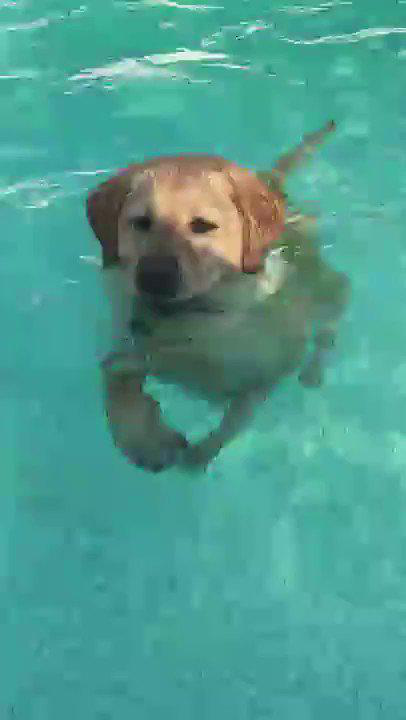

In [136]:
print("Top Retweeted Dog (....also top favorite dog) | Dog Breed :", top_dog_breed)
Image.open("output/top_retweeted_dog.jpg")

Top Rated Dog named Atticus| Dog Breed : bow_tie


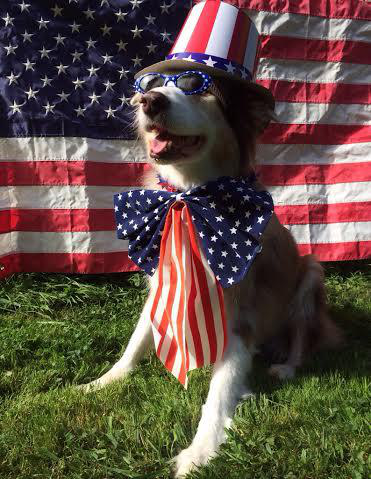

In [137]:
print("Top Rated Dog named "+top_rated_dog_name+"| Dog Breed :", top_rated_dog_breed)
Image.open("output/top_rated_dog.jpg")

### Visualization

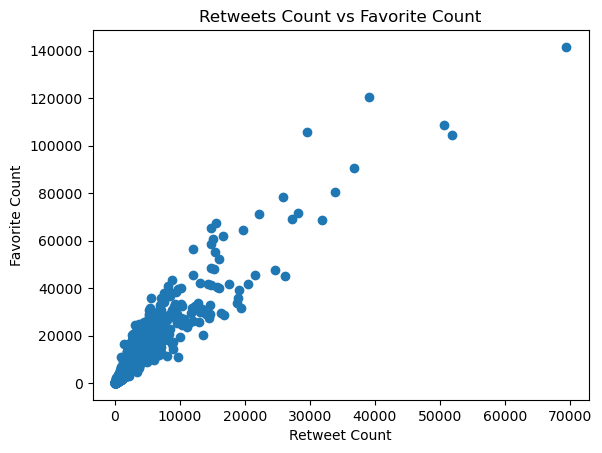

In [138]:
plt.scatter(twitter_archive_master.retweet_count, twitter_archive_master.favorite_count)
plt.xlabel('Retweet Count')
plt.ylabel('Favorite Count')
plt.title('Retweets Count vs Favorite Count');

From the visualization above we can see a positive correlation between retweet count and favorites count